## [04] Spatial Analysis :: Geographically Weighted Regression
Asst. Prof. Chan, Chun-Hsiang
Department of Geography, National Taiwan Normal University, Taipei, Taiwan.

This is a demo class for geographically weighted regression, parallel-computing verion multi-scale/ normal geographically weighted regression, multi-scale geographically weighted regression.<br/>
This tutorial is originated from https://pyrosm.readthedocs.io/en/latest/basics.html#read-buildings.<br/>
If you have any question about this code, plz feel free to ask me.<br/>
Email: chchan@ntnu.edu.tw<br/>
Website: https://toodou.github.io/<br/>
YouTube: https://www.youtube.com/channel/UC22FsanjPFPeXJtly4qVgYQ

In [1]:
# import packages
import numpy as np
import libpysal as ps
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
import geopandas as gp
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib
import pandas as pd
from mgwr.sel_bw import Sel_BW
np.float = float

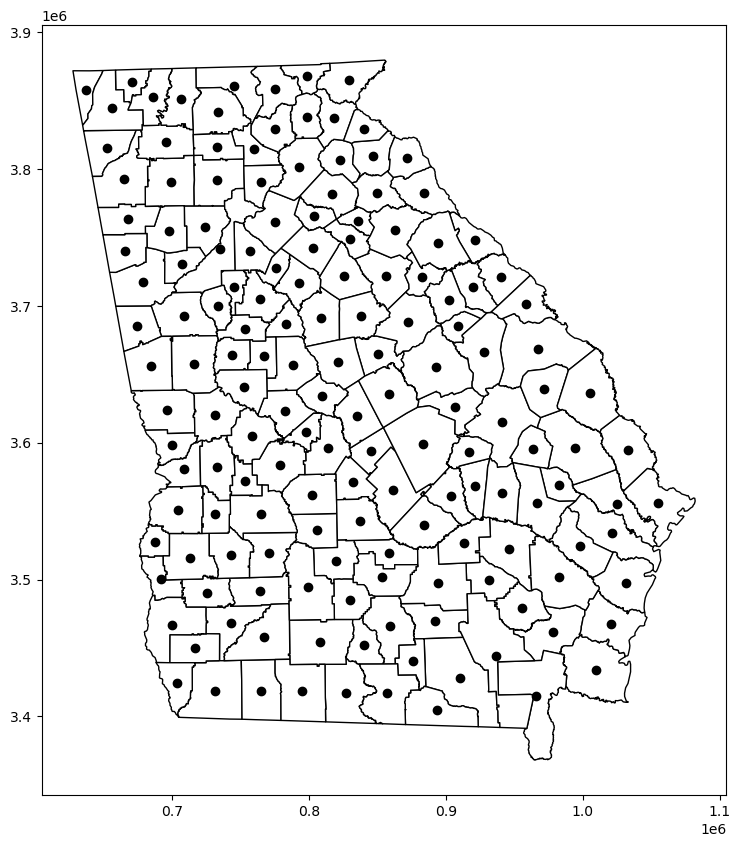

In [2]:
# load Georgia dataset and generate plot of Georgia counties
georgia_data = pd.read_csv(ps.examples.get_path('GData_utm.csv'))
georgia_shp = gp.read_file(ps.examples.get_path('G_utm.shp'))
# plot dataset
fig, ax = plt.subplots(figsize=(10,10))
georgia_shp.plot(ax=ax, **{'edgecolor':'black', 'facecolor':'white'})
georgia_shp.centroid.plot(ax=ax, c='black')
plt.show()

## Data Preprocessing

In [3]:
# prepare Georgia dataset inputs
g_y = georgia_data['PctBach'].values.reshape((-1,1))
g_X = georgia_data[['PctFB', 'PctBlack', 'PctRural']].values
u = georgia_data['X']
v = georgia_data['Y']
g_coords = list(zip(u,v))
# standarized independent variables
g_X = (g_X - g_X.mean(axis=0)) / g_X.std(axis=0)
# reshape
g_y = g_y.reshape((-1,1))
# standarized dependent variables
g_y = (g_y - g_y.mean(axis=0)) / g_y.std(axis=0)

## Geographically Weighted Regression

In [4]:
# calibrate GWR model
gwr_selector = Sel_BW(g_coords, g_y, g_X)
gwr_bw = gwr_selector.search(bw_min=2)
# print the GWR bandwidth
print(gwr_bw)
# fit GWR model
gwr_results = GWR(g_coords, g_y, g_X, gwr_bw).fit()

117.0


In [5]:
# get GWR AIC
gwr_results.aic

296.6159229519982

In [6]:
# get the local R2 of GWR model
gwr_results.localR2[0:10]

array([[0.55932878],
       [0.5148705 ],
       [0.54751792],
       [0.50691577],
       [0.69062134],
       [0.69429812],
       [0.69813709],
       [0.70867337],
       [0.49985703],
       [0.49379842]])

In [7]:
# print the GWR model summary
gwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                 159
Number of covariates:                                                     4

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                             71.793
Log-likelihood:                                                    -162.399
AIC:                                                                332.798
AICc:                                                               335.191
BIC:                                                               -713.887
R2:                                                                   0.548
Adj. R2:                                                              0.540

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

## Parallel Version Multi-Scale/ Normal Geographically Weighted Regression

In [8]:
# import packages
import numpy as np
import geopandas as gp
import multiprocessing as mp
import libpysal as ps
import sys
sys.path.append('/Users/Ziqi/Desktop/mgwr/')
from mgwr.gwr import GWR,MGWR

In [9]:
# load Berlin example
prenz = gp.read_file(ps.examples.get_path('prenzlauer.zip'))

In [10]:
# data preprocessing for GWR
b_y = np.log(prenz['price'].values.reshape((-1, 1)))
b_X = prenz[['review_sco','accommodat','bathrooms']].values
# standardize dataset
b_X = (b_X - b_X.mean(axis=0)) / b_X.std(axis=0)
b_y = (b_y - b_y.mean(axis=0)) / b_y.std(axis=0)
u = prenz['X']
v = prenz['Y']
b_coords = list(zip(u, v))

In [11]:
# this might be needed to turn off the OpenMP multi-threading
%env OMP_NUM_THREADS = 1

env: OMP_NUM_THREADS=1


In [12]:
# parrallelization is more favored when you your data are large and/or your machine have many many cores.
# mgwr has soft dependency of numba, please install numba if you need better performance (pip install numba).
n_proc = 2 # two processors => you can adjust to other number of cores depending on your computer
pool = mp.Pool(n_proc)

In [13]:
%%time
# select bandwidth
gwr_selector = Sel_BW(b_coords, b_y, b_X)
# add pool to Sel_BW.search
gwr_bw = gwr_selector.search(pool=pool) 
# print bandwidth
print(gwr_bw)
# fit the geographically weighted regression
gwr_results = GWR(b_coords, b_y, b_X, gwr_bw).fit(pool=pool) #add pool to GWR.fit

192.0
CPU times: user 75.1 ms, sys: 15.5 ms, total: 90.6 ms
Wall time: 3.35 s


In [14]:
%%time
# select bandwidth
mgwr_selector = Sel_BW(b_coords, b_y, b_X, multi=True)
# add pool to Sel_BW.search
mgwr_bw = mgwr_selector.search(pool=pool) 
# print bandwidth
print(mgwr_bw)
# fit the multi-scale geographically weighted regression
mgwr_results = MGWR(b_coords, b_y, b_X, selector=mgwr_selector).fit(pool=pool) #add pool to MGWR.fit

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

[ 191. 1279.   79. 2200.]


Inference:   0%|          | 0/2 [00:00<?, ?it/s]

CPU times: user 1.59 s, sys: 235 ms, total: 1.82 s
Wall time: 34.8 s


In [15]:
# Close the pool when you finish
pool.close()
pool.join()

In [16]:
# print MGWR result
mgwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                2203
Number of covariates:                                                     4

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                           1603.640
Log-likelihood:                                                   -2776.147
AIC:                                                               5560.294
AICc:                                                              5562.321
BIC:                                                             -15323.328
R2:                                                                   0.272
Adj. R2:                                                              0.271

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

## GWR Prediction

In [17]:
# import packages
import numpy as np
import libpysal as ps 
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
from mgwr.utils import shift_colormap, truncate_colormap
import geopandas as gp
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

In [18]:
# prepare Georgia dataset inputs
g_y = georgia_data['PctBach'].values.reshape((-1,1))
g_X = georgia_data[['PctFB', 'PctBlack', 'PctRural']].values
u = georgia_data['X']
v = georgia_data['Y']
g_coords = list(zip(u,v))
# standarized independent variables
g_X = (g_X - g_X.mean(axis=0)) / g_X.std(axis=0)
# reshpe
g_y = g_y.reshape((-1,1))
# standarized dependent variables
g_y = (g_y - g_y.mean(axis=0)) / g_y.std(axis=0)

In [19]:
# calibrate GWR model
gwr_selector = Sel_BW(g_coords, g_y, g_X)
gwr_bw = gwr_selector.search(bw_min=2)
print(gwr_bw)
gwr_results = GWR(g_coords, g_y, g_X, gwr_bw).fit()

117.0


In [20]:
# calibrate MGWR model
mgwr_selector = Sel_BW(g_coords, g_y, g_X, multi=True)
mgwr_bw = mgwr_selector.search(multi_bw_min=[2])
print(mgwr_bw)
mgwr_results = MGWR(g_coords, g_y, g_X, mgwr_selector).fit()

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

[ 92. 101. 136. 158.]


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

In [21]:
# print MGWR result
mgwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                 159
Number of covariates:                                                     4

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                             71.793
Log-likelihood:                                                    -162.399
AIC:                                                                332.798
AICc:                                                               335.191
BIC:                                                               -713.887
R2:                                                                   0.548
Adj. R2:                                                              0.540

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [22]:
# prepare GWR results for mapping
# add GWR parameters to GeoDataframe
georgia_shp['gwr_intercept'] = gwr_results.params[:,0]
georgia_shp['gwr_fb'] = gwr_results.params[:,1]
georgia_shp['gwr_aa'] = gwr_results.params[:,2]
georgia_shp['gwr_rural'] = gwr_results.params[:,3]
# obtain t-values filtered based on multiple testing correction
gwr_filtered_t = gwr_results.filter_tvals()

In [23]:
# prepare MGWR results for mapping
# add MGWR parameters to GeoDataframe
georgia_shp['mgwr_intercept'] = mgwr_results.params[:,0]
georgia_shp['mgwr_fb'] = mgwr_results.params[:,1]
georgia_shp['mgwr_aa'] = mgwr_results.params[:,2]
georgia_shp['mgwr_rural'] = mgwr_results.params[:,3]
# obtain t-values filtered based on multiple testing correction
mgwr_filtered_t = mgwr_results.filter_tvals()

In [24]:
# prepare colormap
def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    '''
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero.

    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower offset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to 
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax / (vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highest point in the colormap's range.
          Defaults to 1.0 (no upper offset). Should be between
          `midpoint` and 1.0.
    '''
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }

    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)
    #plt.register_cmap(cmap=newcmap)

    return newcmap

### Plot Intercept Map

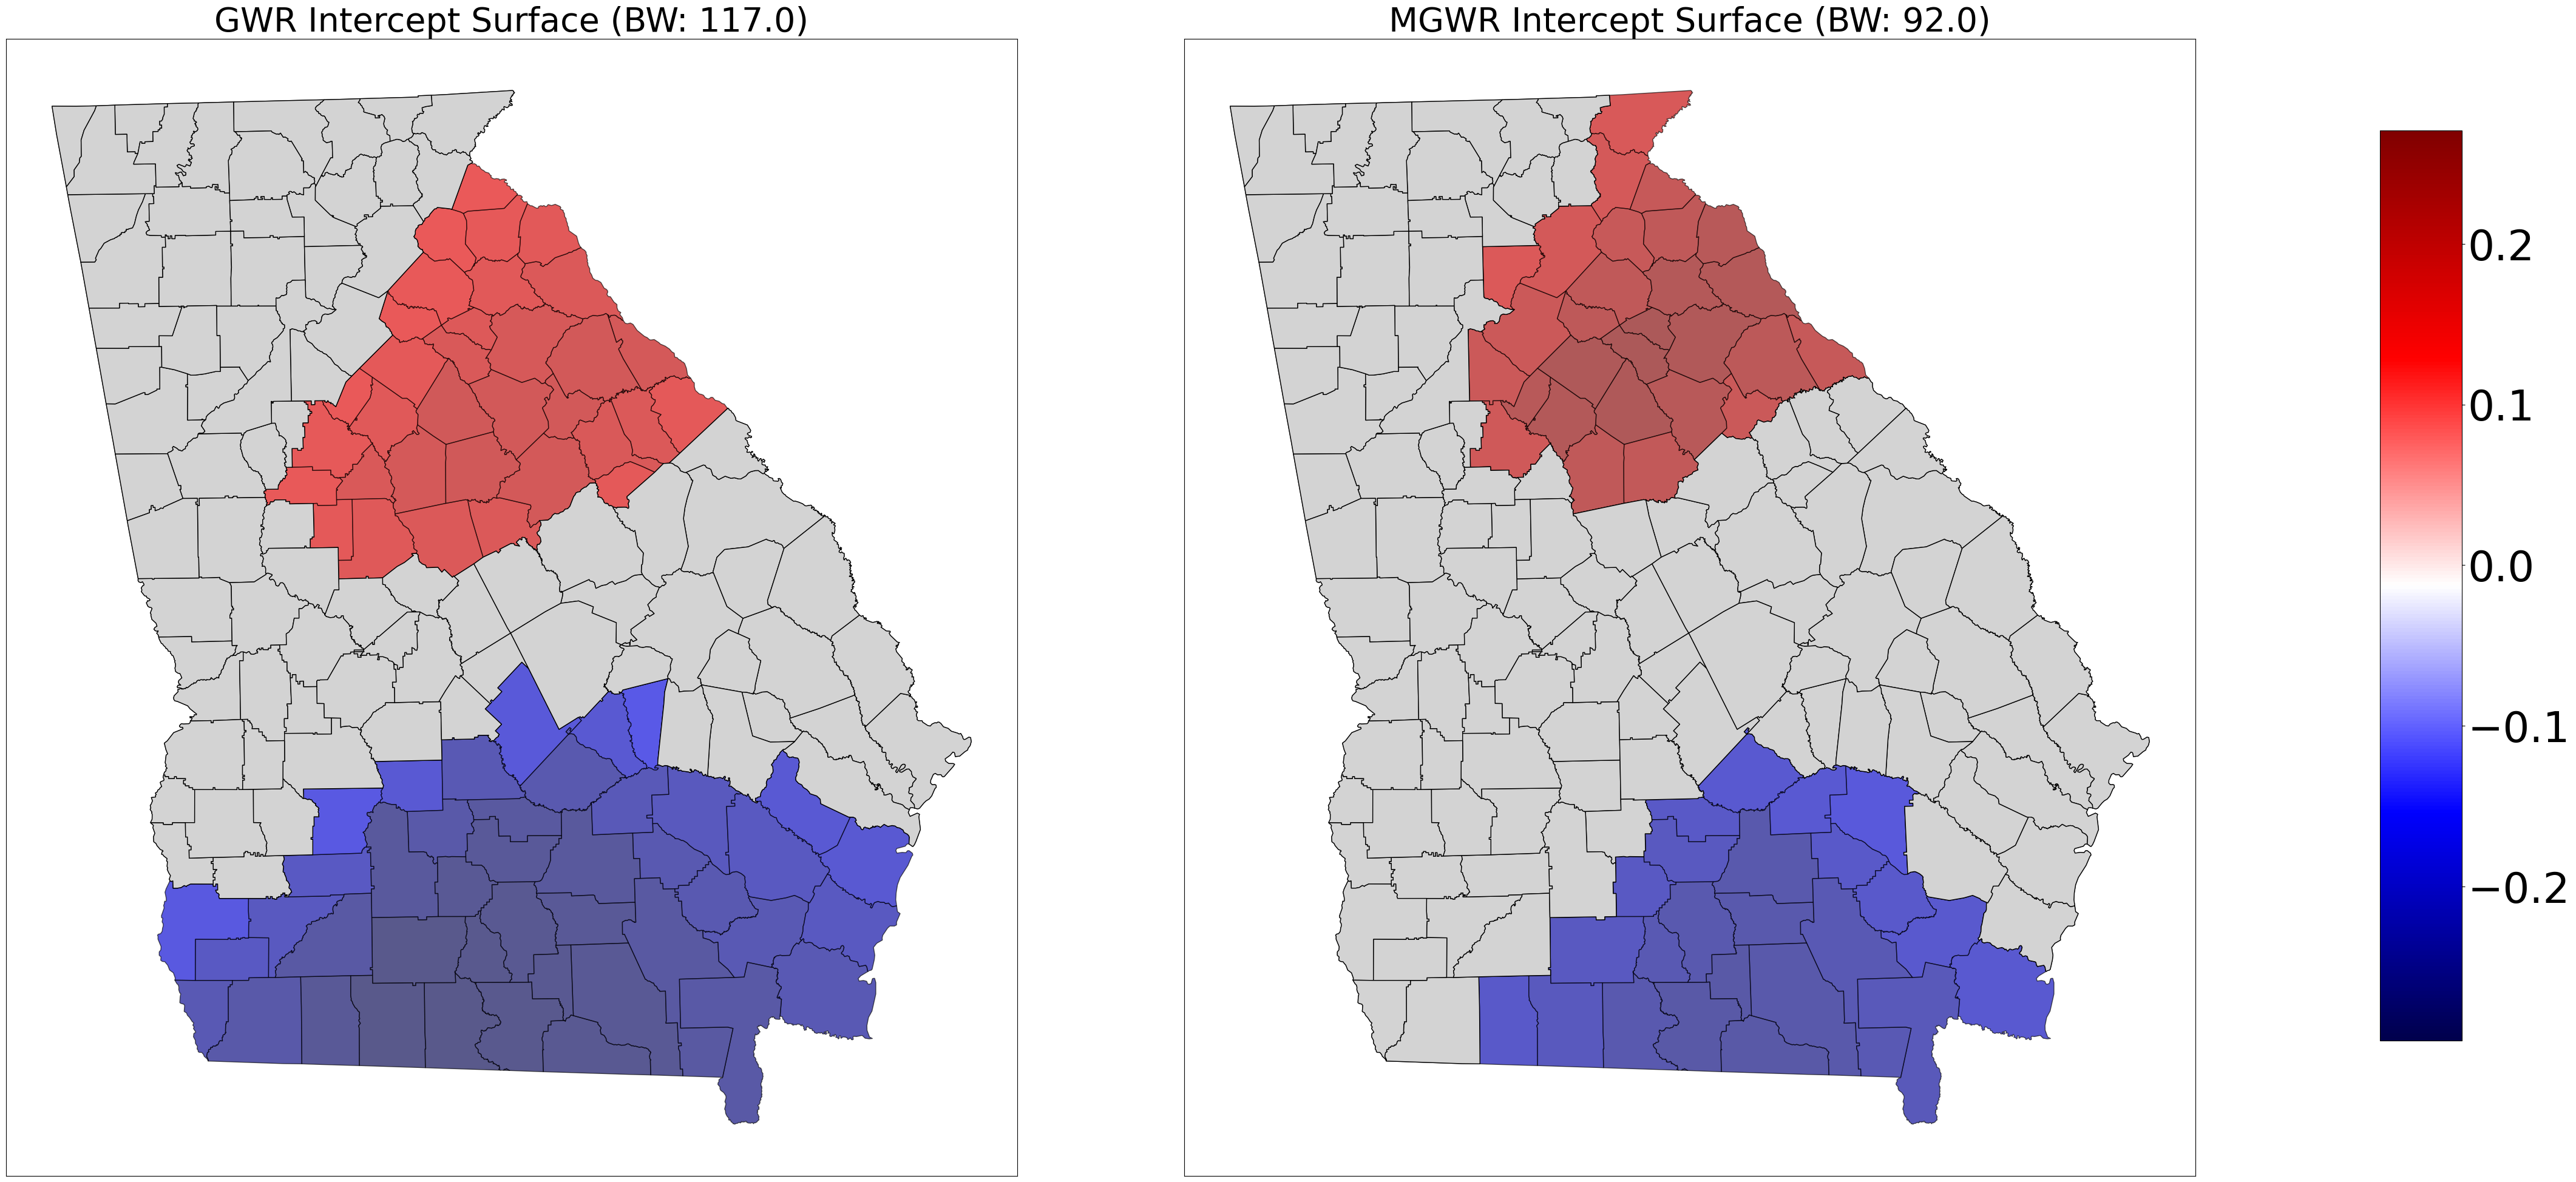

In [39]:
# comparison maps of GWR vs. MGWR parameter surfaces where the grey units pertain to statistically insignificant parameters
# prepare plot and add axes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(45,20))
ax0 = axes[0]
ax0.set_title('GWR Intercept Surface (BW: ' + str(gwr_bw) +')', fontsize=40)
ax1 = axes[1]
ax1.set_title('MGWR Intercept Surface (BW: ' + str(mgwr_bw[0]) +')', fontsize=40)

# set color map
cmap = plt.cm.seismic

# find min and max values of the two combined datasets
gwr_min = georgia_shp['gwr_intercept'].min()
gwr_max = georgia_shp['gwr_intercept'].max()
mgwr_min = georgia_shp['mgwr_intercept'].min()
mgwr_max = georgia_shp['mgwr_intercept'].max()
vmin = np.min([gwr_min, mgwr_min])
vmax = np.max([gwr_max, mgwr_max])

# create scalar mappable for colorbar and stretch colormap across range of data values
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))

# plot GWR parameters
georgia_shp.plot('gwr_intercept', cmap=sm.cmap, ax=ax0, vmin=vmin, vmax=vmax, **{'edgecolor':'black', 'alpha':.65})
#If there are insignificnt parameters plot gray polygons over them
if (gwr_filtered_t[:,0] == 0).any():
    georgia_shp[gwr_filtered_t[:,0] == 0].plot(color='lightgrey', ax=ax0, **{'edgecolor':'black'})

# plot MGWR parameters
georgia_shp.plot('mgwr_intercept', cmap=sm.cmap, ax=ax1, vmin=vmin, vmax=vmax, **{'edgecolor':'black', 'alpha':.65})
#If there are insignificnt parameters plot gray polygons over them
if (mgwr_filtered_t[:,0] == 0).any():
    georgia_shp[mgwr_filtered_t[:,0] == 0].plot(color='lightgrey', ax=ax1, **{'edgecolor':'black'})
 
# set figure options and plot 
fig.tight_layout()    
fig.subplots_adjust(right=0.9)
cax = fig.add_axes([0.92, 0.14, 0.03, 0.75])
sm._A = []
cbar = fig.colorbar(sm, cax=cax)
cbar.ax.tick_params(labelsize=50) 
ax0.get_xaxis().set_visible(False)
ax0.get_yaxis().set_visible(False)
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
plt.show()

### Plot GWR Percent Foreign Born Surface

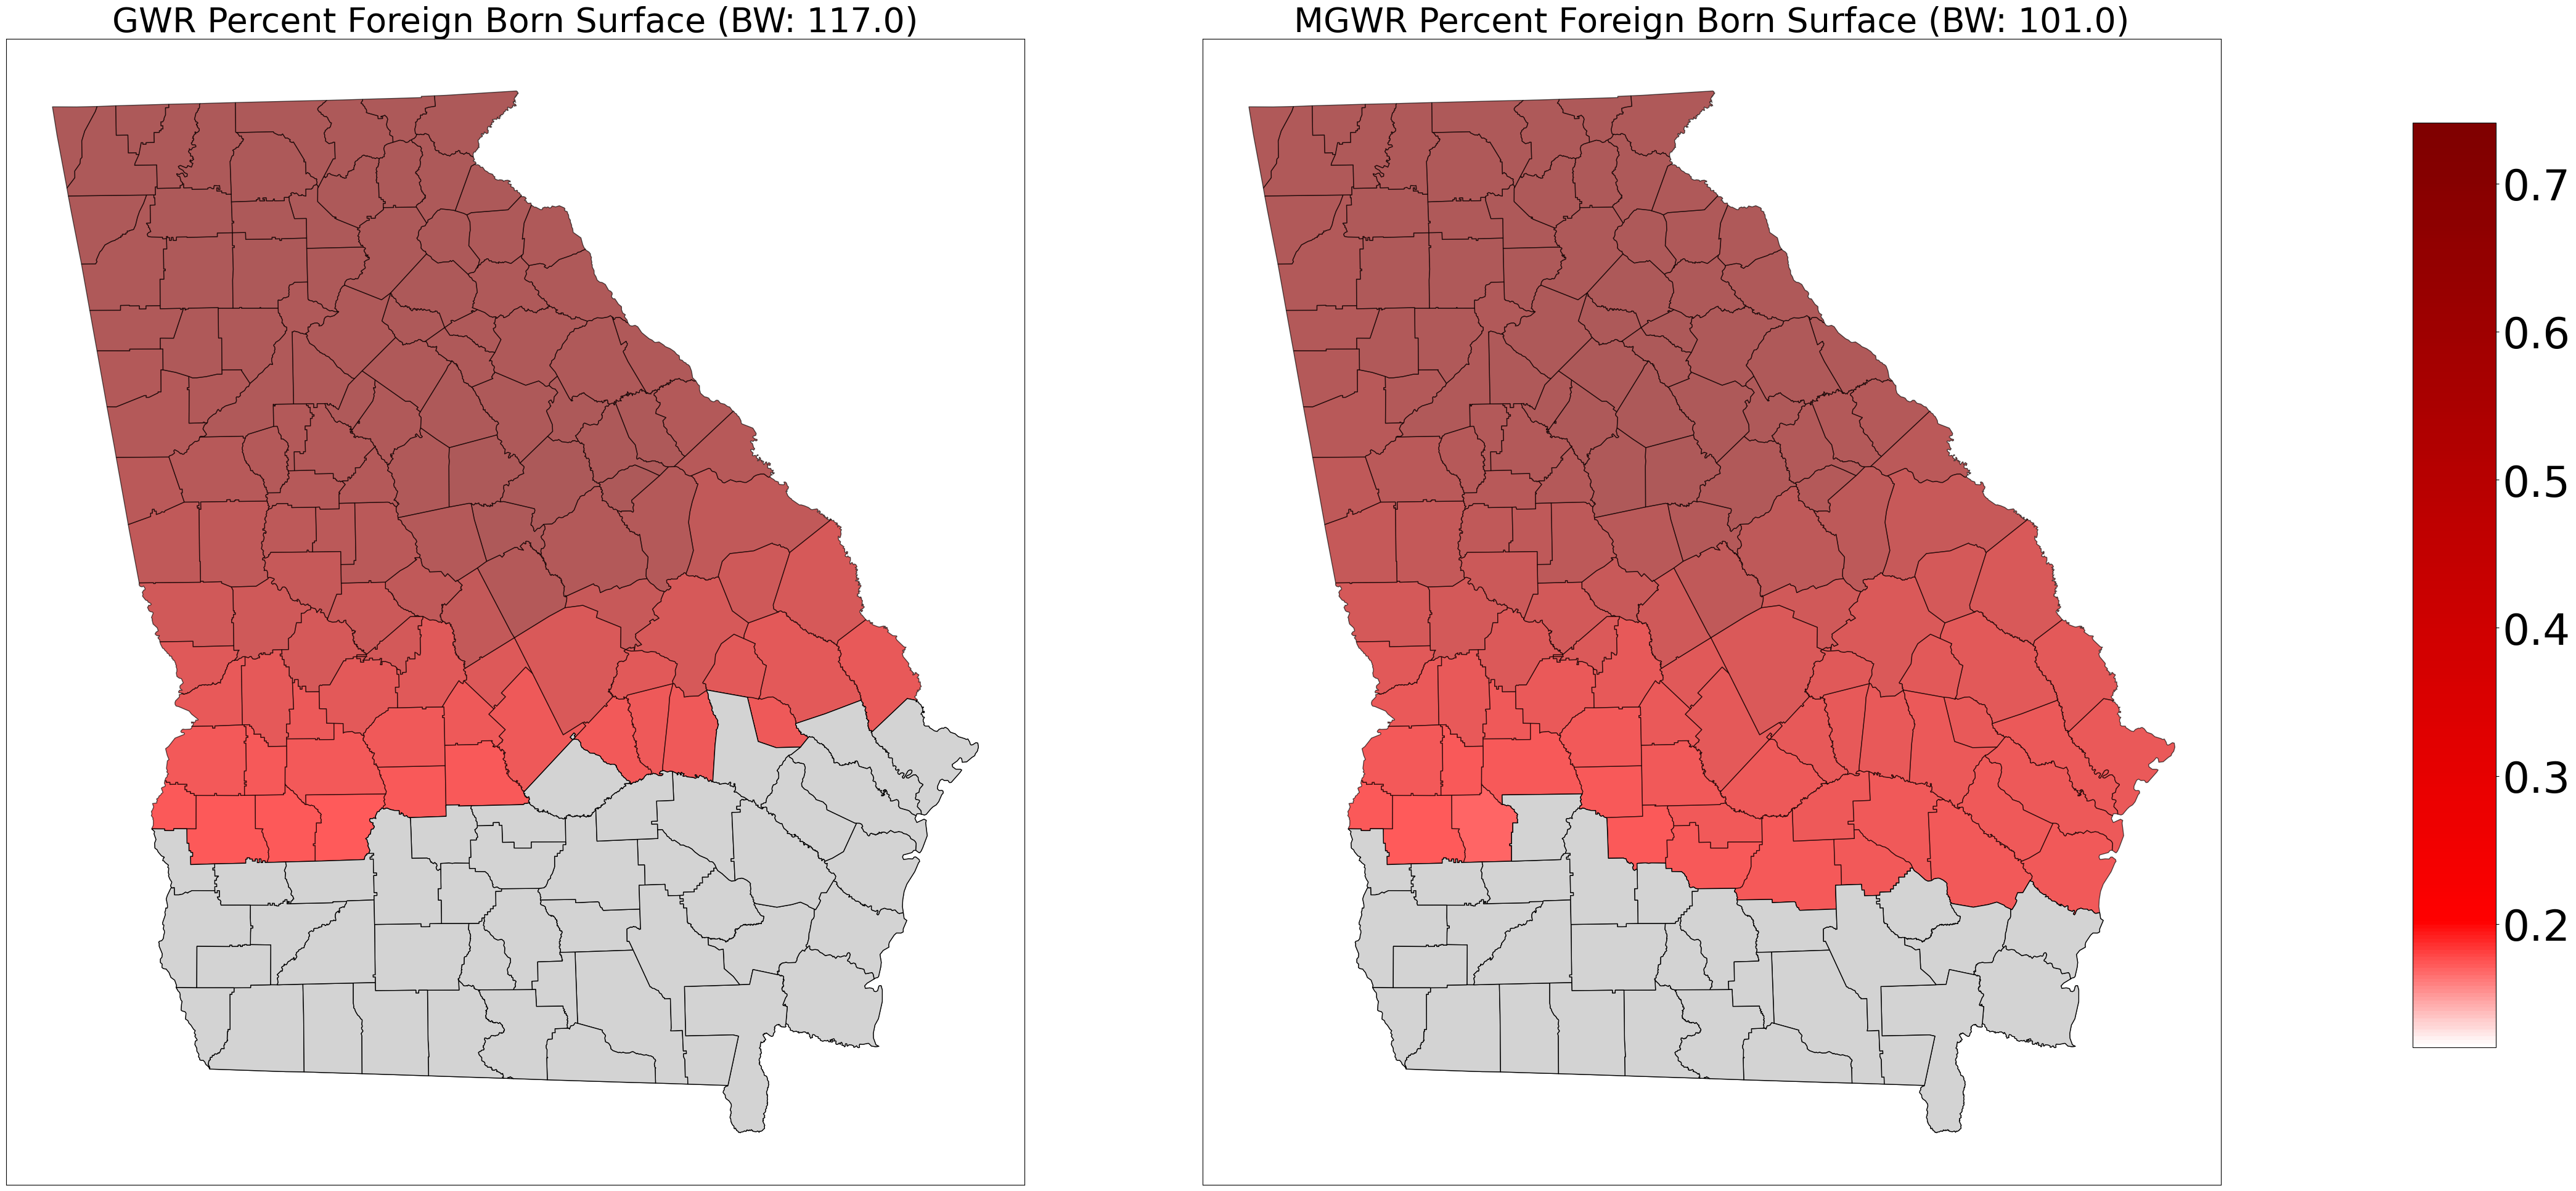

In [26]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(45,20))
ax0 = axes[0]
ax0.set_title('GWR Percent Foreign Born Surface (BW: ' + str(gwr_bw) +')', fontsize=40)
ax1 = axes[1]
ax1.set_title('MGWR Percent Foreign Born Surface (BW: ' + str(mgwr_bw[1]) +')', fontsize=40)
cmap = plt.cm.seismic
gwr_min = georgia_shp['gwr_fb'].min()
gwr_max = georgia_shp['gwr_fb'].max()
mgwr_min = georgia_shp['mgwr_fb'].min()
mgwr_max = georgia_shp['mgwr_fb'].max()
vmin = np.min([gwr_min, mgwr_min])
vmax = np.max([gwr_max, mgwr_max])

if (vmin < 0) & (vmax < 0):
    cmap = truncate_colormap(cmap, 0.0, 0.5)
elif (vmin > 0) & (vmax > 0):
    cmap = truncate_colormap(cmap, 0.5, 1.0)

cmap = shiftedColorMap(cmap, start=0.0, midpoint=1 - vmax/(vmax + abs(vmin)), stop=1.)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))

georgia_shp.plot('gwr_fb', cmap=sm.cmap, ax=ax0, vmin=vmin, vmax=vmax, **{'edgecolor':'black', 'alpha':.65})
if (gwr_filtered_t[:,1] == 0).any():
    georgia_shp[gwr_filtered_t[:,1] == 0].plot(color='lightgrey', ax=ax0, **{'edgecolor':'black'})

georgia_shp.plot('mgwr_fb', cmap=sm.cmap, ax=ax1, vmin=vmin, vmax=vmax, **{'edgecolor':'black', 'alpha':.65})
if (mgwr_filtered_t[:,1] == 0).any():
    georgia_shp[mgwr_filtered_t[:,1] == 0].plot(color='lightgrey', ax=ax1, **{'edgecolor':'black'})
   
fig.tight_layout()
fig.subplots_adjust(right=0.9)
cax = fig.add_axes([0.92, 0.14, 0.03, 0.75])
sm._A = []
cbar = fig.colorbar(sm, cax=cax)
cbar.ax.tick_params(labelsize=50) 
ax0.get_xaxis().set_visible(False)
ax0.get_yaxis().set_visible(False)
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
plt.show()

### Plot Percent African American Surface

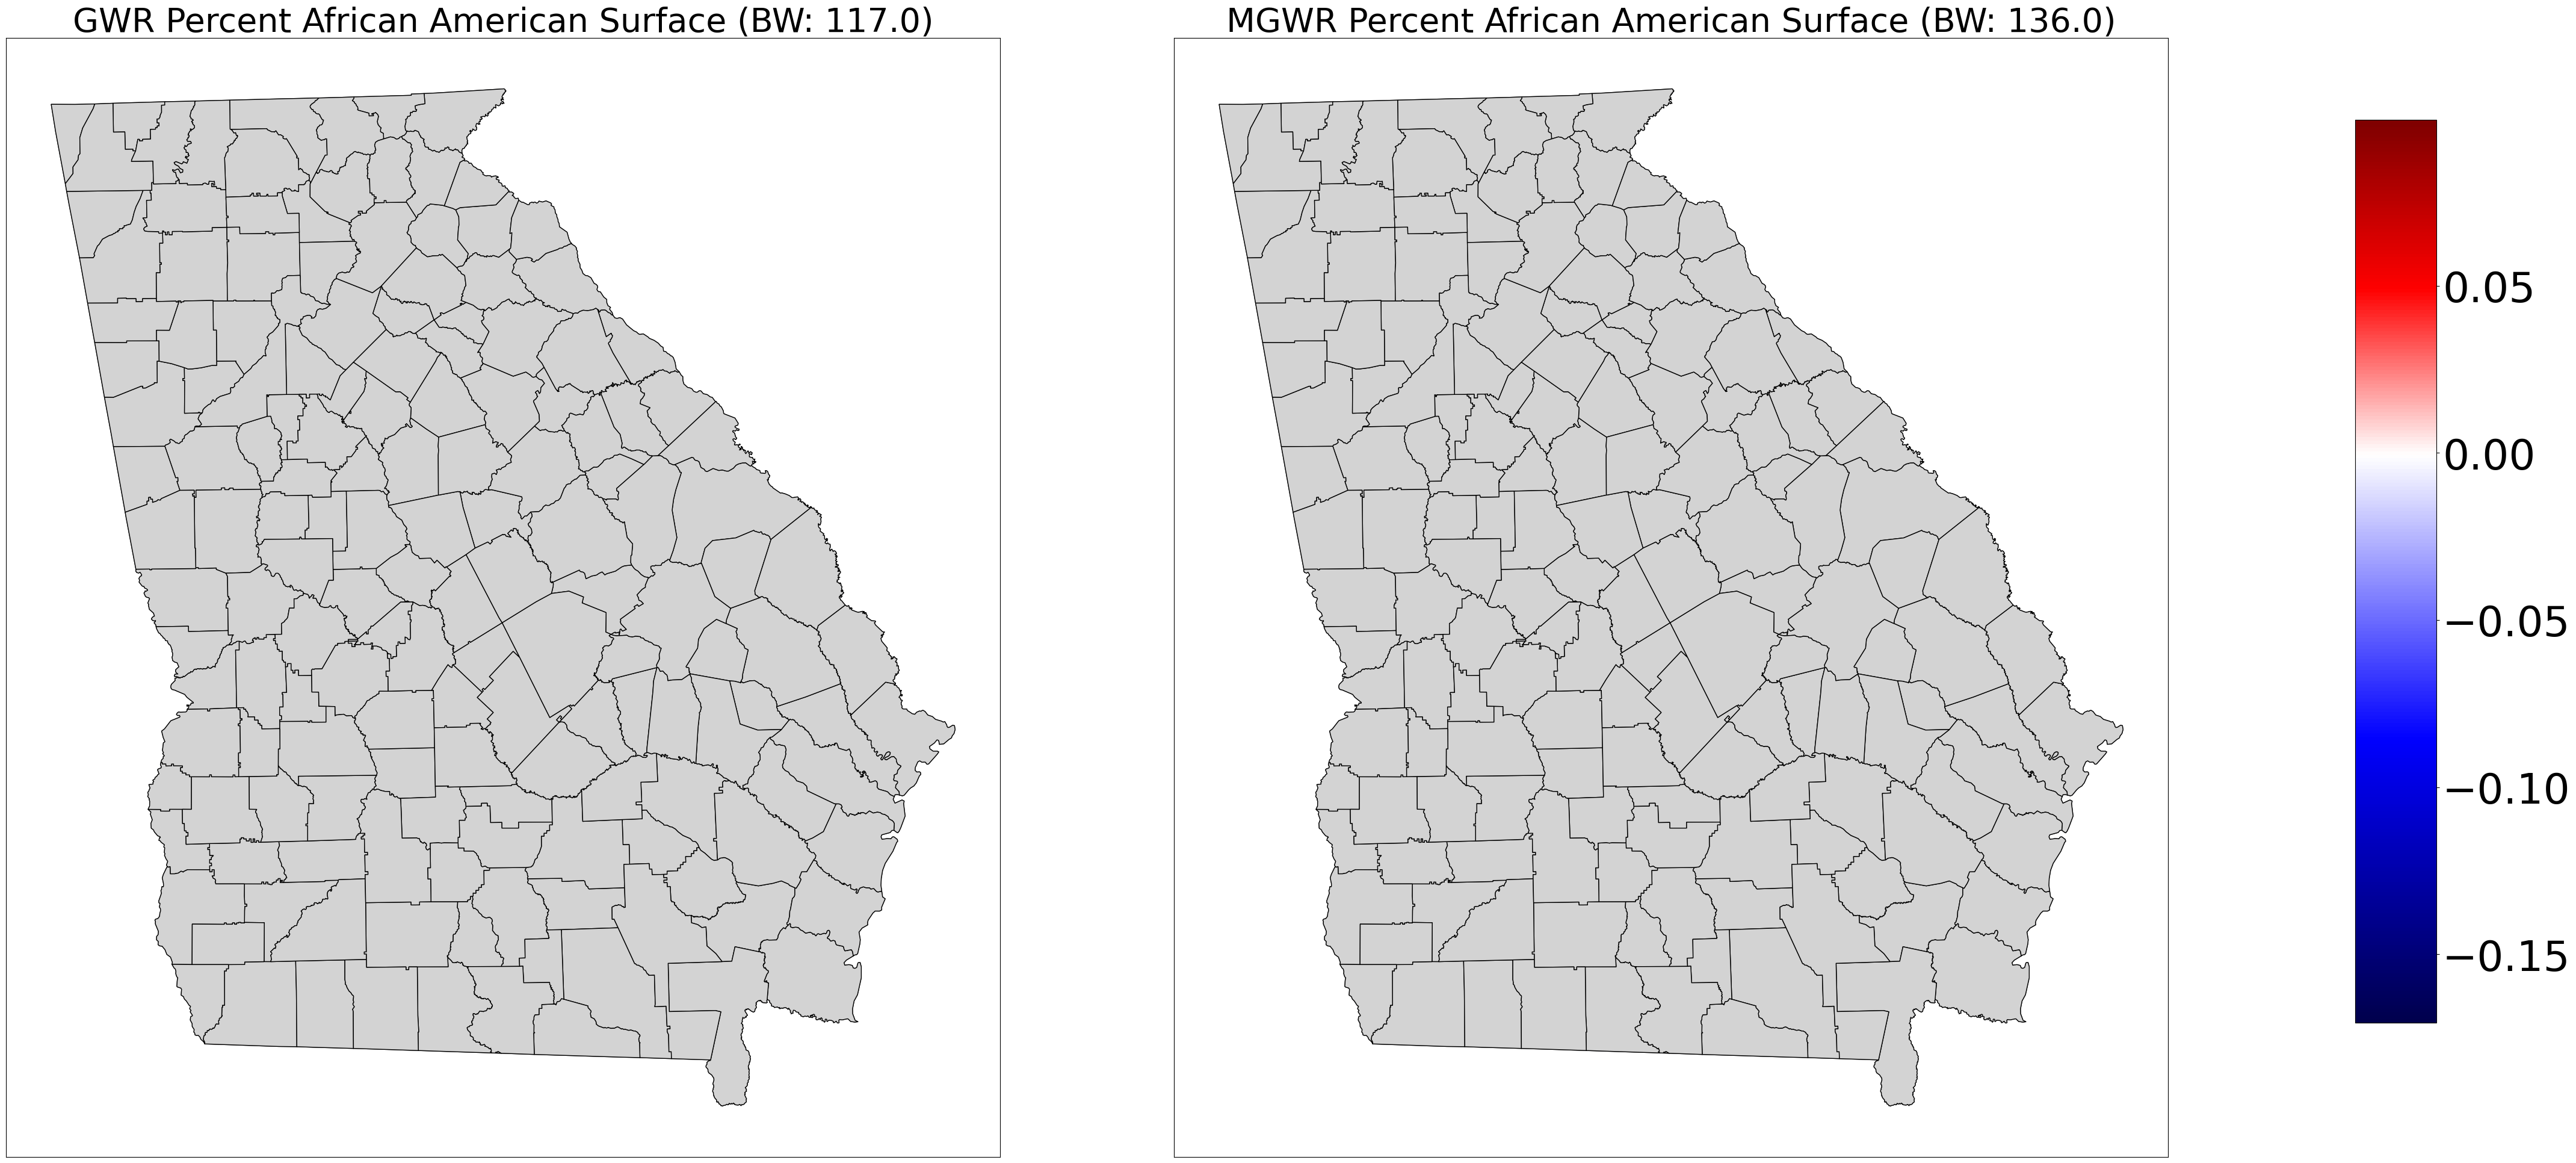

In [31]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(45,20))
ax0 = axes[0]
ax0.set_title('GWR Percent African American Surface (BW: ' + str(gwr_bw) +')', fontsize=40)
ax1 = axes[1]
ax1.set_title('MGWR Percent African American Surface (BW: ' + str(mgwr_bw[2]) +')', fontsize=40)
cmap = plt.cm.seismic
gwr_min = georgia_shp['gwr_aa'].min()
gwr_max = georgia_shp['gwr_aa'].max()
mgwr_min = georgia_shp['mgwr_aa'].min()
mgwr_max = georgia_shp['mgwr_aa'].max()
vmin = np.min([gwr_min, mgwr_min])
vmax = np.max([gwr_max, mgwr_max])

if (vmin < 0) & (vmax < 0):
    cmap = truncate_colormap(cmap, 0.0, 0.5)
elif (vmin > 0) & (vmax > 0):
    cmap = truncate_colormap(cmap, 0.5, 1.0)
else:
    cmap = shiftedColorMap(cmap, start=0.0, midpoint=1 - vmax/(vmax + abs(vmin)), stop=1.)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))

georgia_shp.plot('gwr_aa', cmap=sm.cmap, ax=ax0, vmin=vmin, vmax=vmax, **{'edgecolor':'black', 'alpha':.65})
if (gwr_filtered_t[:,2] == 0).any():
    georgia_shp[gwr_filtered_t[:,2] == 0].plot(color='lightgrey', ax=ax0, **{'edgecolor':'black'})

georgia_shp.plot('mgwr_aa', cmap=sm.cmap, ax=ax1, vmin=vmin, vmax=vmax, **{'edgecolor':'black', 'alpha':.65})
if (mgwr_filtered_t[:,2] == 0).any():
    georgia_shp[mgwr_filtered_t[:,2] == 0].plot(color='lightgrey', ax=ax1, **{'edgecolor':'black'})
    
fig.tight_layout()    
fig.subplots_adjust(right=0.9)
cax = fig.add_axes([0.92, 0.14, 0.03, 0.75])
sm._A = []
cbar = fig.colorbar(sm, cax=cax)
cbar.ax.tick_params(labelsize=50) 
ax0.get_xaxis().set_visible(False)
ax0.get_yaxis().set_visible(False)
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
plt.show()

### Plot Percent Rural Surface

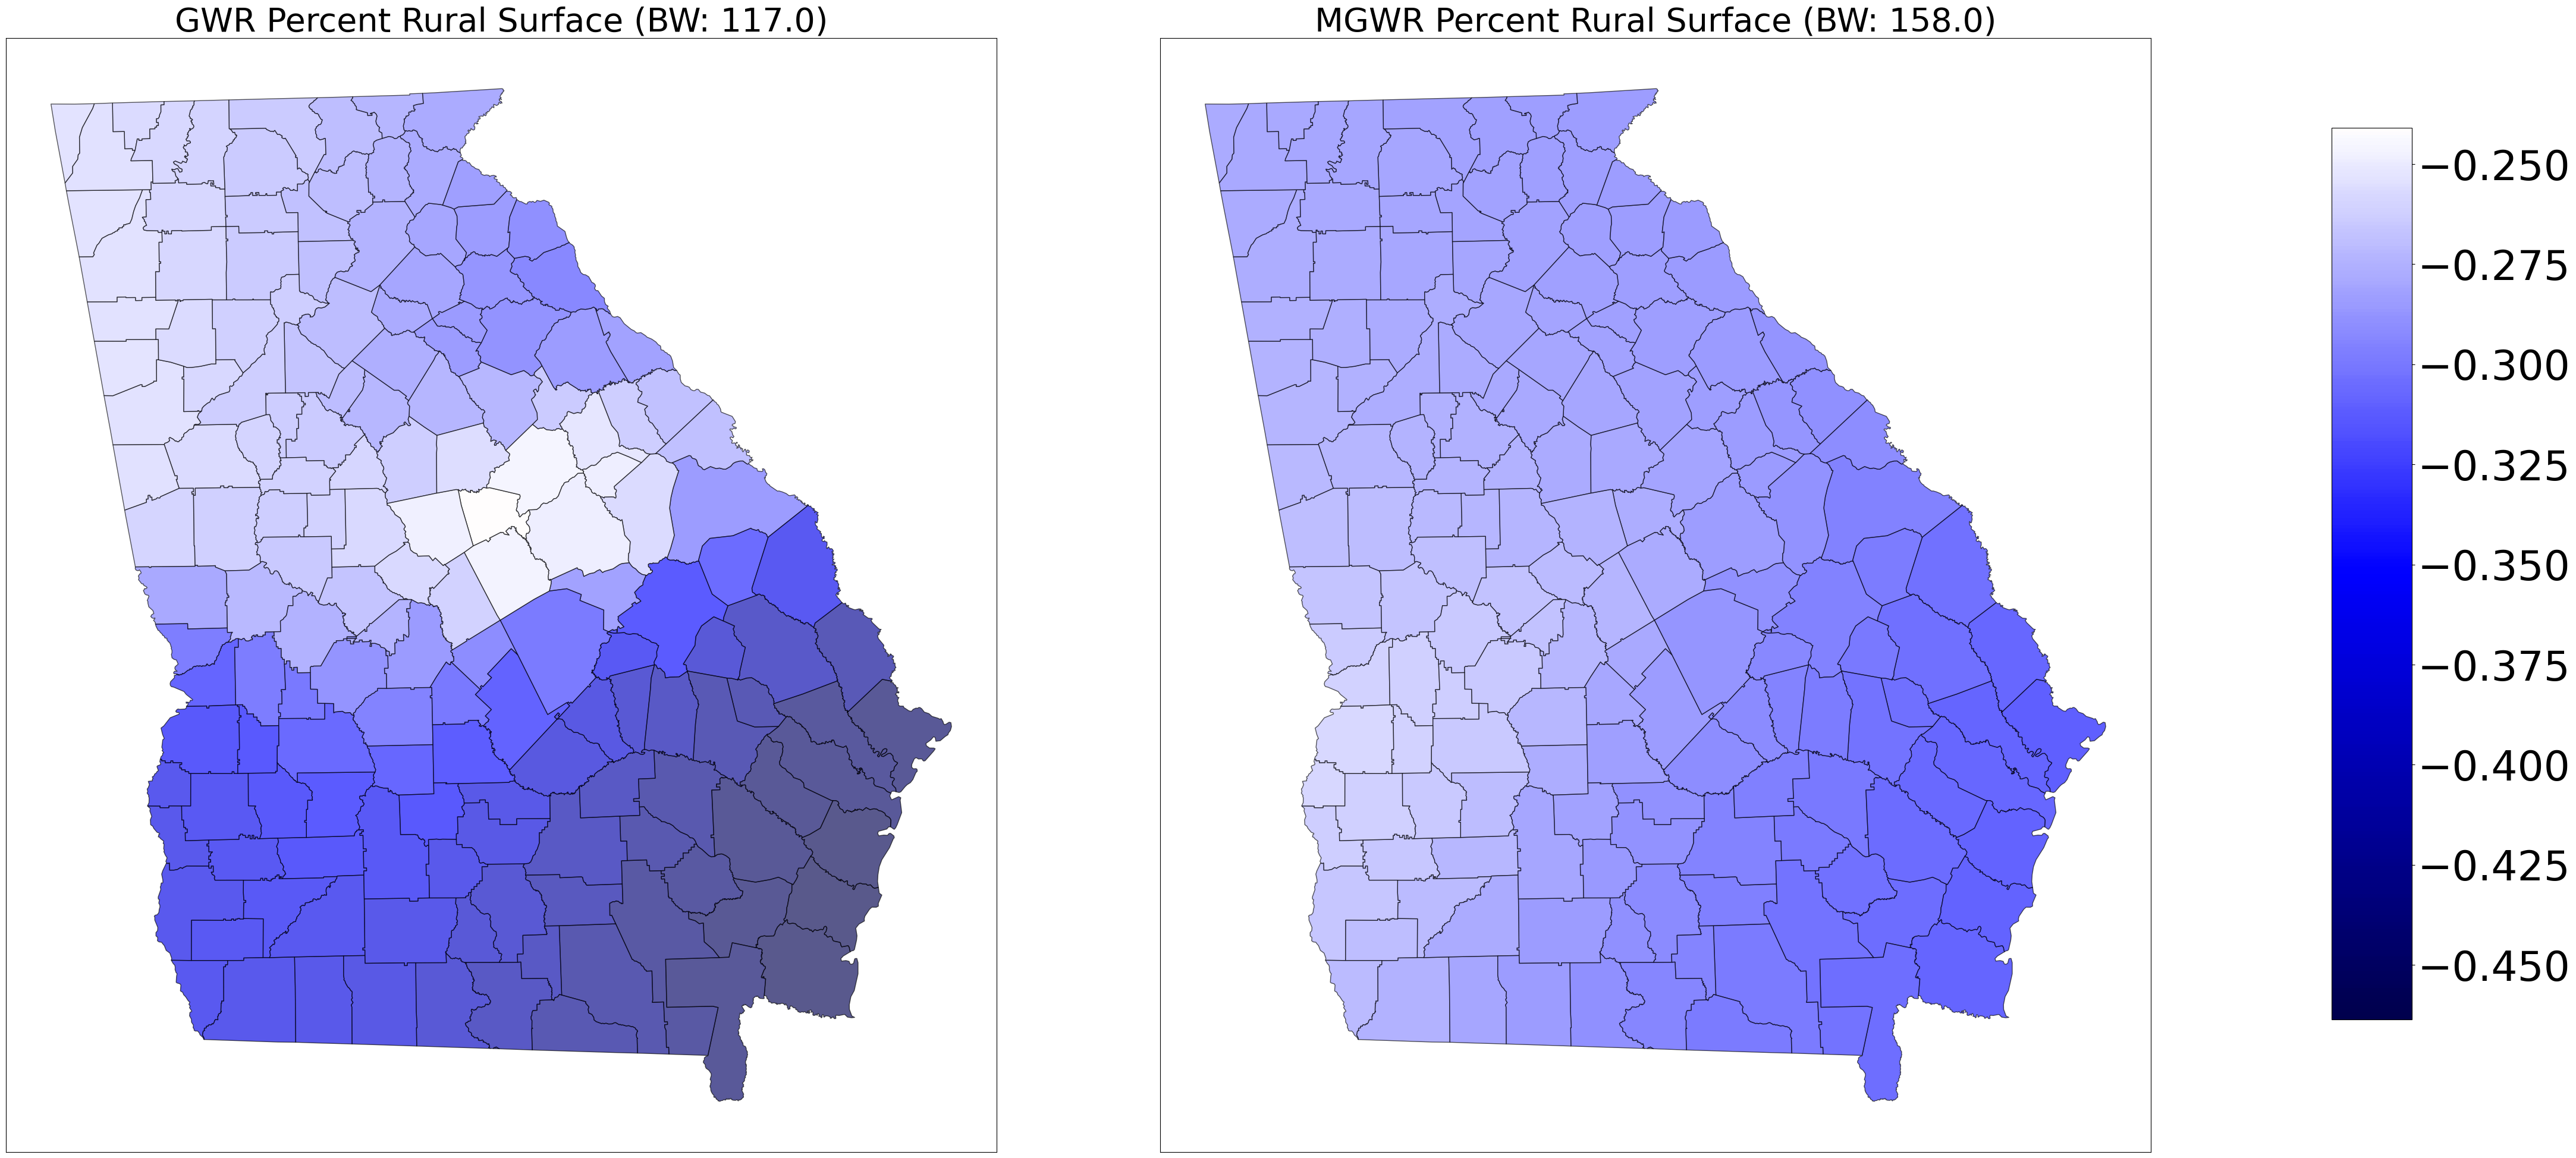

In [28]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(45,20))
ax0 = axes[0]
ax0.set_title('GWR Percent Rural Surface (BW: ' + str(gwr_bw) +')', fontsize=40)
ax1 = axes[1]
ax1.set_title('MGWR Percent Rural Surface (BW: ' + str(mgwr_bw[3]) +')', fontsize=40)
cmap = plt.cm.seismic
gwr_min = georgia_shp['gwr_rural'].min()
gwr_max = georgia_shp['gwr_rural'].max()
mgwr_min = georgia_shp['mgwr_rural'].min()
mgwr_max = georgia_shp['mgwr_rural'].max()
vmin = np.min([gwr_min, mgwr_min])
vmax = np.max([gwr_max, mgwr_max])

if (vmin < 0) & (vmax < 0):
    cmap = truncate_colormap(cmap, 0.0, 0.5)
elif (vmin > 0) & (vmax > 0):
    cmap = truncate_colormap(cmap, 0.5, 1.0)
else:
    cmap = shiftedColorMap(cmap, start=0.0, midpoint=1 - vmax/(vmax + abs(vmin)), stop=1.)
    
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))

georgia_shp.plot('gwr_rural', cmap=sm.cmap, ax=ax0, vmin=vmin, vmax=vmax, **{'edgecolor':'black', 'alpha':.65})
if (gwr_filtered_t[:,3] == 0).any():
    georgia_shp[gwr_filtered_t[:,3] == 0].plot(color='lightgrey', ax=ax0, **{'edgecolor':'black'})

georgia_shp.plot('mgwr_rural', cmap=sm.cmap, ax=ax1, vmin=vmin, vmax=vmax, **{'edgecolor':'black', 'alpha':.65})
if (mgwr_filtered_t[:,3] == 0).any():
    georgia_shp[mgwr_filtered_t[:,3] == 0].plot(color='lightgrey', ax=ax1, **{'edgecolor':'black'})

fig.tight_layout()    
fig.subplots_adjust(right=0.9)
cax = fig.add_axes([0.92, 0.14, 0.03, 0.75])
sm._A = []
cbar = fig.colorbar(sm, cax=cax)
cbar.ax.tick_params(labelsize=50) 
ax0.get_xaxis().set_visible(False)
ax0.get_yaxis().set_visible(False)
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
plt.show()